<a href="https://colab.research.google.com/github/Chahinezehallaci/Chahinezehallaci/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L'objectif est:

*   utiliser des stratégies étudiées dans le cours de statistique en grande dimension (Lasso, SVM, NMF, Boosting,...).

*   utiliser une stratégie de clustering, une stratégie de sélection de variable, et une stratégie de prédiction.

  


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#%cd /content/drive/MyDrive/Dataset_Celisse_Projet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_error



In [ ]:
titanic = pd.read_csv("/content/drive/MyDrive/Dataset_Celisse_Projet/titanic.csv")
train = pd.read_csv("/content/drive/MyDrive/Dataset_Celisse_Projet/train-data.csv")
train['type']=1
test = pd.read_csv("/content/drive/MyDrive/Dataset_Celisse_Projet/test-data.csv")
test['type']=0

In [ ]:
df = pd.concat([train,test])

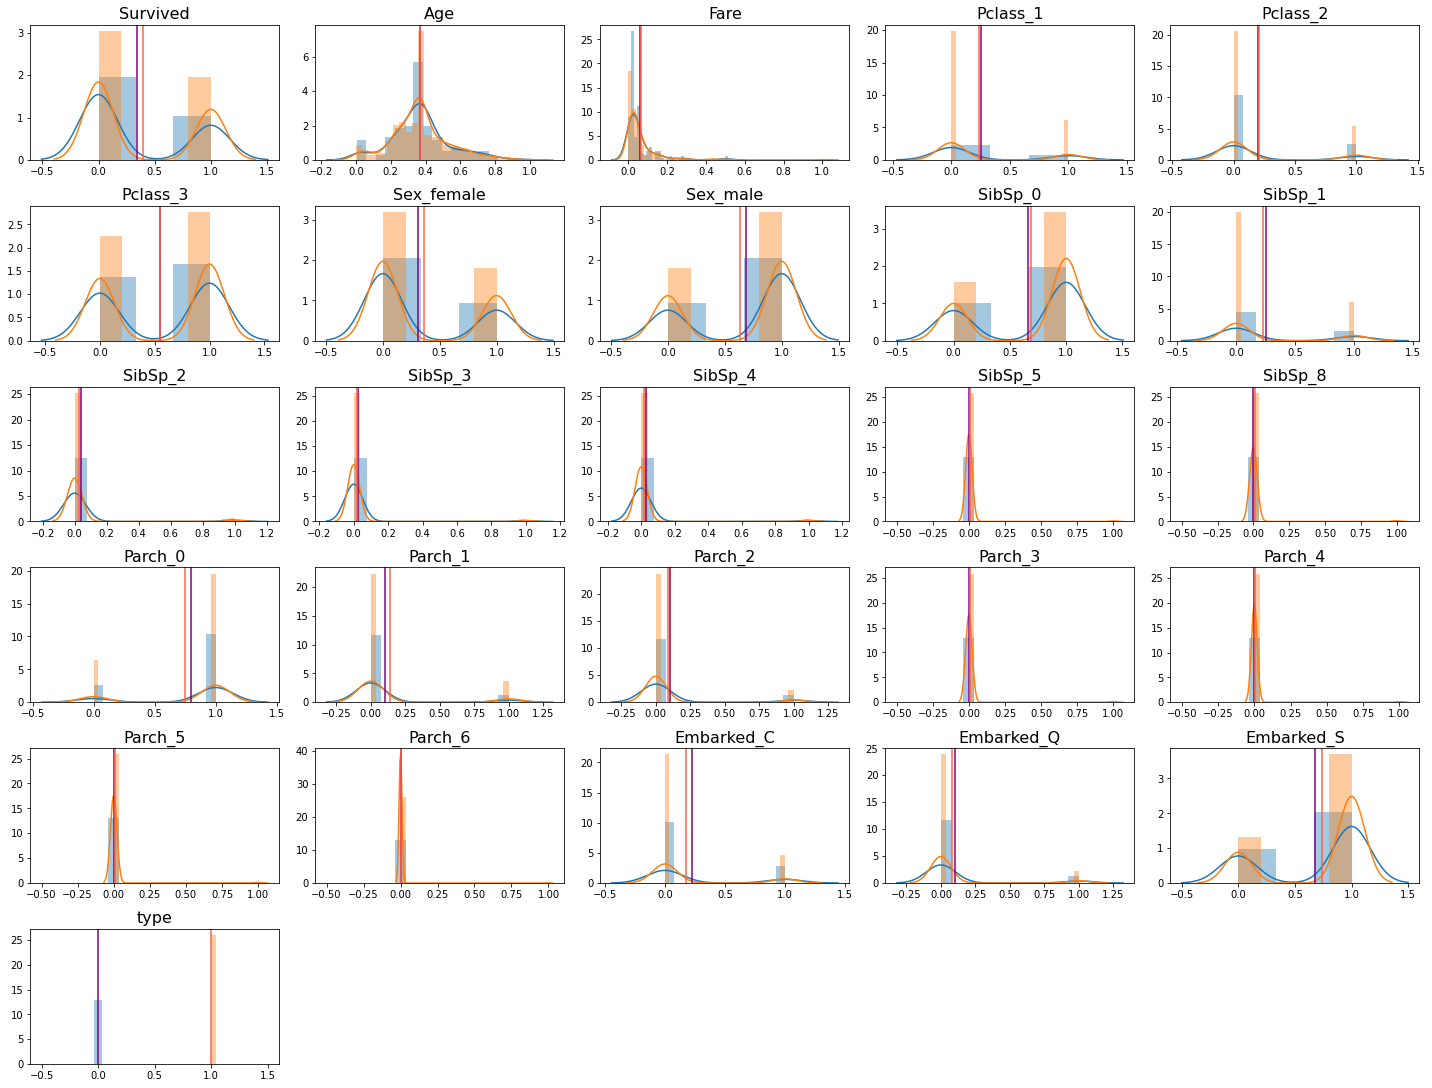

In [ ]:
#Comparaison entre test y train
plt.rcParams['figure.figsize']=(20, 20)
rows = 8; cols = 5
for index, (colname, serie) in enumerate(df.iteritems()):
    plt.subplot(rows, cols, index + 1)
    serie1 = df[df['type'] == 0][colname].dropna()
    serie2= df[df['type'] == 1][colname].dropna()
    if (pd.api.types.is_float_dtype(serie1) or pd.api.types.is_integer_dtype(serie1) or pd.api.types.is_bool_dtype(serie1)) is True:
        sns.distplot(serie1)
        sns.distplot(serie2)
        plt.axvline(np.mean(serie1), color='purple')
        plt.axvline(np.mean(serie2), color='tomato')
    elif (pd.api.types.is_object_dtype(serie1)) is True:
        sns.countplot(serie)
    plt.title(colname, fontsize=16)
    plt.xlabel('');plt.ylabel('');plt.tight_layout()

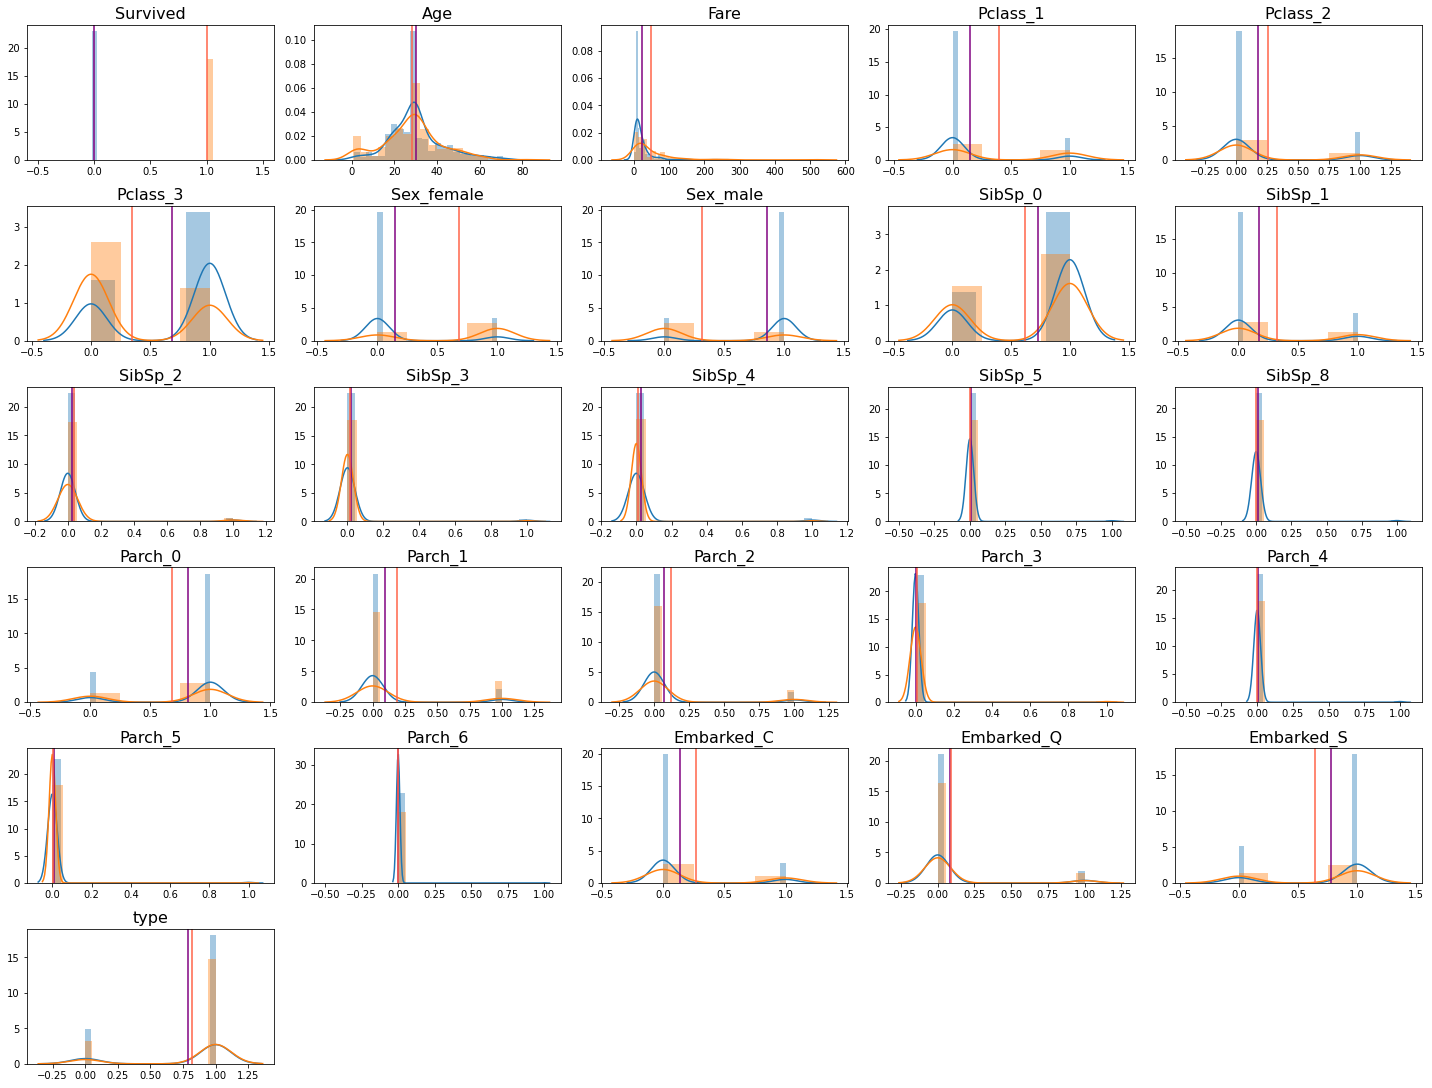

In [ ]:
#Comparaison entre Survived y Non Survived
plt.rcParams['figure.figsize']=(20, 20)
rows = 8; cols = 5
for index, (colname, serie) in enumerate(df.iteritems()):
    plt.subplot(rows, cols, index + 1)
    serie1 = df[df['Survived'] == 0][colname].dropna()
    serie2= df[df['Survived'] == 1][colname].dropna()
    if (pd.api.types.is_float_dtype(serie1) or pd.api.types.is_integer_dtype(serie1) or pd.api.types.is_bool_dtype(serie1)) is True:
        sns.distplot(serie1)
        sns.distplot(serie2)
        plt.axvline(np.mean(serie1), color='purple')
        plt.axvline(np.mean(serie2), color='tomato')
    elif (pd.api.types.is_object_dtype(serie1)) is True:
        sns.countplot(serie)
    plt.title(colname, fontsize=16)
    plt.xlabel('');plt.ylabel('');plt.tight_layout()

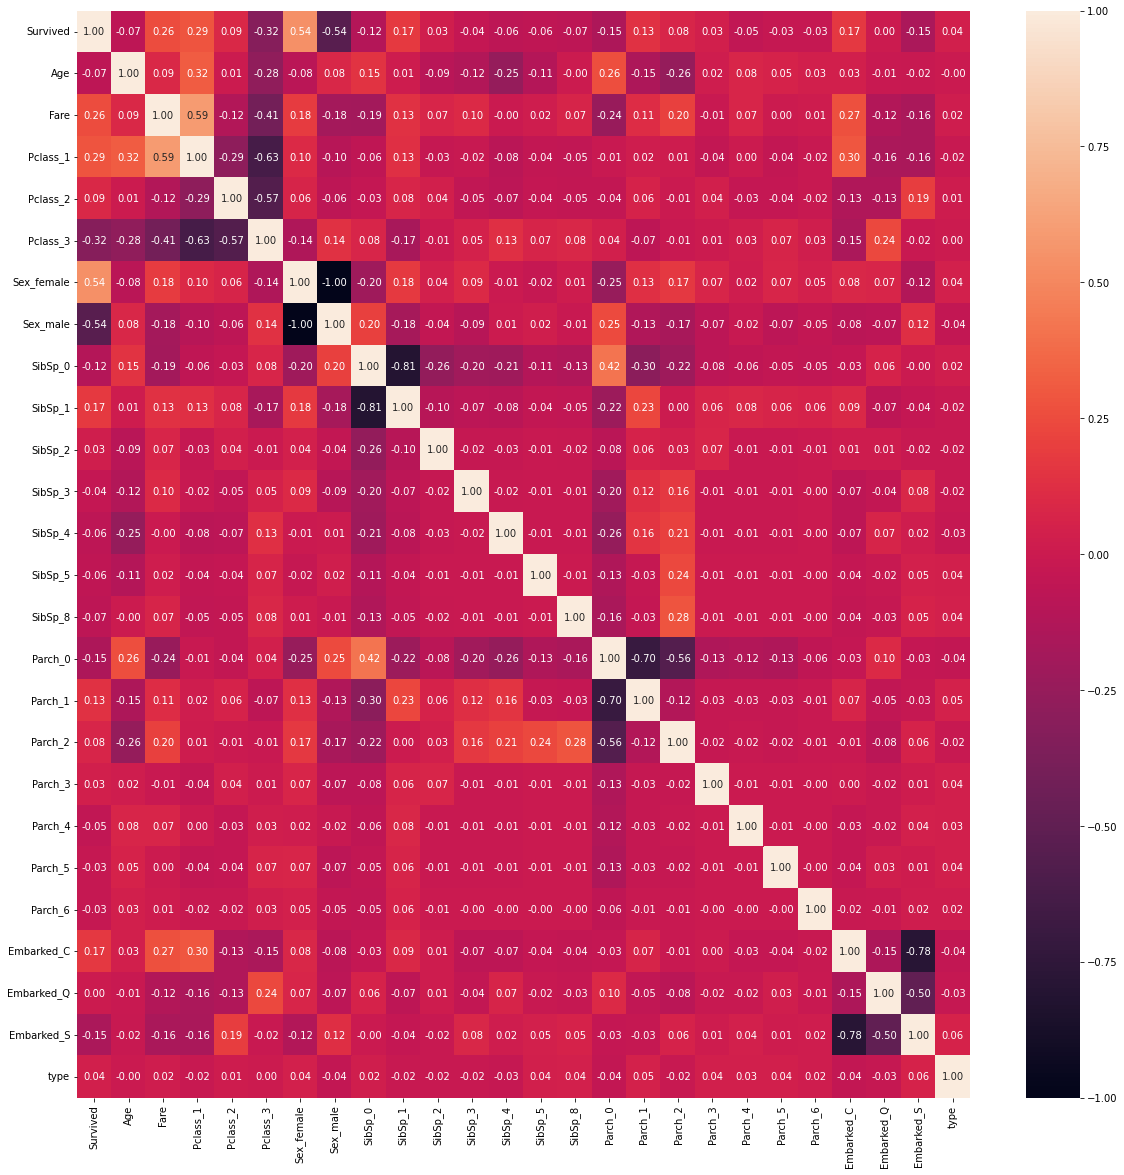

In [ ]:
plt.rcParams['figure.figsize']=(20, 20)
sns.heatmap(df.corr(), fmt='.2f', annot=True)

In [ ]:
train_x = train
train_y = train['Survived']
train_x.drop('Survived', axis = 1, inplace = True)

In [ ]:
test_x = test
test_y = test['Survived']
test_x.drop('Survived', axis = 1, inplace = True)

###Selection de variables - Analyse en Composantes Principales

Le jeu de donnees consolide est constitue de 891 observations de 25 variables. Cela ne pose pas de problematique de grande dimension (ici n >> d). Cependant nous nous preterons a l'exercice de selection de variables pour les raisons suivantes :
- nous demontrerons notre bonne comprehension d'un outil selectionne (ici l'analyse en composantes principales), de son utilisation et de son interpretation ;
- nous utiliserons cet outil pour identifier les axes expliquant le mieux la dispersion des donnees ;
- nous selectionnerons les 3 axes principaux identifies pour effectuer une visualisation en 3D des donnees ;
- nous comparerons les resultats de nos predictions avec et sans utiliser le resultat de notre selection de variables.

Nous utiliserons l'outil de reduction de dimensionnalite lineaire *PCA* de *scikit-learn*.

source : https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [ ]:
from sklearn.decomposition import PCA

Cette methode centre deja elle-meme les donnees d'entree mais ne les mets pas a l'echelle. Commencons donc par nous occuper des variables "Age" et "Fare" qui doivent l'etre. Nous utiliserons pour cela le transformateur *MinMaxScaler* de *scikit-learn*.

source : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df_PCA = df
mms = MinMaxScaler()
df_PCA[["Age", "Fare"]] = mms.fit_transform(df[["Age", "Fare"]])

La methode *PCA* utilise la decomposition en valeurs singulieres afin de projeter les donnees dans un espace de donnees inferieur.

Une fois la matrice de valeurs singulieres obtenues, une reduction de dimensionnalite peut etre effectuee en fixant les coefficients diagonaux les plus faibles a 0.

*Note : il est notamment possible d'obtenir ces valeurs singulieres via les methodes linalg.svd de numpy et de scipy (exemples ci-dessous).*

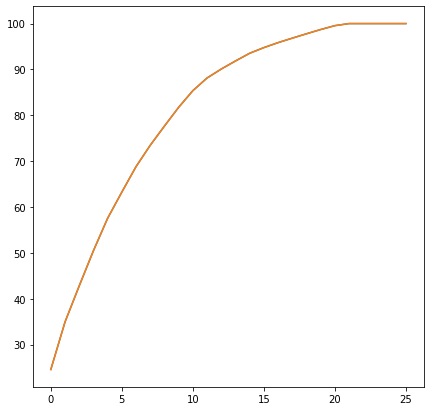

In [ ]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.plot(np.cumsum(np.linalg.svd(df_PCA)[1]) / np.linalg.svd(df_PCA)[1].sum() * 100);
plt.plot(np.cumsum(sp.linalg.svd(df_PCA)[1]) / sp.linalg.svd(df_PCA)[1].sum() * 100);

Pour rappel, l'analyse en composantes principales est une methode non supervisee de reduction de dimensionnalite. Ainsi il faut bien comprendre que les axes identifies par cette methode ne l'ont pas ete a partir de la variable que nous cherchons a expliquer (survie ou non). Pour de telles methodes supervisees, voir l'analyse des correspondances multiples ou encore l'analyse factorielle de donnees mixtes.


- *n_components* : pour le moment nous garderons autant de composantes que de variables pour obtenir une vision exhaustive des variances expliquees. Nous fixerons ce parametre a 3 ulterieurement lors de notre visualisation 3D.

In [ ]:
pca = PCA(n_components = df_PCA.shape[1])
pca.fit(df_PCA)
df_PCA = pca.transform(df_PCA)

La liste suivante nous indique que les 8 premieres composantes principales expliquent 90% de la variance des donnees, alors que 10 composantes en expliquent 95%.

In [ ]:
for i in range(df_PCA.shape[1]):
    print("{:.2f}%".format(pca.explained_variance_ratio_[0 : i + 1].sum() * 100))

24.70%
38.51%
51.43%
63.26%
70.43%
77.38%
83.07%
87.51%
91.22%
94.61%
96.39%
97.25%
97.93%
98.56%
98.91%
99.19%
99.40%
99.60%
99.79%
99.95%
100.00%
100.00%
100.00%
100.00%
100.00%
100.00%


Nous retrouvons bien les memes valeurs singulieres que via la methode *np.linalg.svd*.

In [ ]:
for i in range(pca.singular_values_.shape[0]):
  print("{:.2f}".format(pca.singular_values_[i]))

24.77
18.52
17.92
17.14
13.35
13.14
11.89
10.50
9.60
9.17
6.66
4.61
4.11
3.95
2.96
2.64
2.30
2.23
2.17
2.00
1.06
0.00
0.00
0.00
0.00
0.00


In [ ]:
for i in range(np.linalg.svd(df_PCA)[1].shape[0]):
  print("{:.2f}".format(np.linalg.svd(df_PCA)[1][i]))

24.77
18.52
17.92
17.14
13.35
13.14
11.89
10.50
9.60
9.17
6.66
4.61
4.11
3.95
2.96
2.64
2.30
2.23
2.17
2.00
1.06
0.00
0.00
0.00
0.00
0.00


Visualisons la variance cumulee par composante.

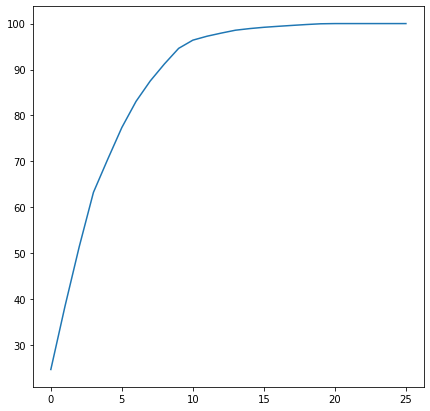

In [ ]:
var_plot = list()
for i in range (df_PCA.shape[1]):
  var_plot.append(pca.explained_variance_ratio_[0 : i + 1].sum() * 100)
plt.plot(var_plot);

Nous pouvons maintenant selectionner les 3 premieres composantes principales pour essayer d'obtenir une visualisation 3D impactantes.

Malheureusement avec une variance expliquee "seulement" a 55% par ces composantes, la visualisation ne donne rien de tres interessant (aucun cluster visible par exemple). Voir ci-dessous.

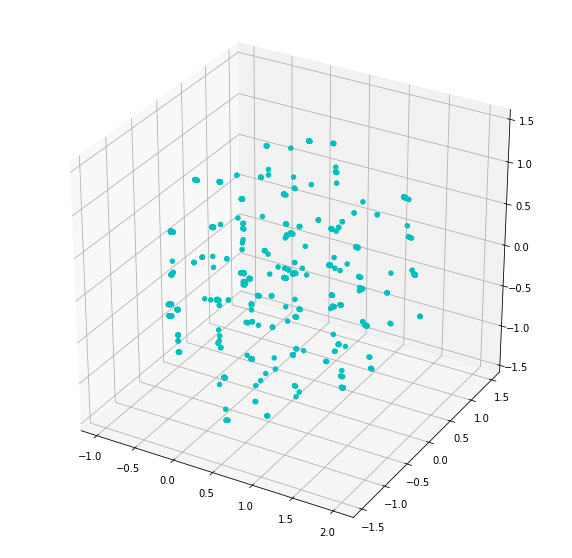

In [ ]:
pca_3d = PCA(n_components = 3, random_state = 42)
pca_3d.fit(df_PCA)
pca_spl_3d = pca_3d.transform(df_PCA)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_spl_3d[:, 0], pca_spl_3d[:, 1], pca_spl_3d[:, 2], alpha=1, color='c');

Pour comparaison lors de nos futures predictions, nous allons selectionner les variables qui influencent le plus les 8 premieres composantes principales (pour 90% de variance expliquee).

In [ ]:
nb_comp = pca.components_.shape[0]
plus_imp = [np.abs(pca.components_[i]).argmax() for i in range(nb_comp)]
plus_imp_nom = [df.columns[plus_imp[i]] for i in range(nb_comp)]
dic = {'PC{}'.format(i): plus_imp_nom[i] for i in range(nb_comp)}
res = pd.DataFrame(dic.items())
res.columns = ["Composante", "Variable influente"]
res

,Composante,Variable influente
0,PC0,Sex_female
1,PC1,SibSp_0
2,PC2,Pclass_3
3,PC3,Embarked_S
4,PC4,Parch_0
5,PC5,Pclass_2
6,PC6,type
7,PC7,Survived
8,PC8,Parch_2
9,PC9,Embarked_Q


Nous pouvons en deduire que les variables les plus inflentes sont les suivantes :
- Sex_female ;
- SibSp_0;
- Pclass_3 ;
- Embarked_S ;
- Parch_0 ;
- P_class2 ;
- Survived (qu'ici nous ignorerons car variable a expliquer) ;
- Parch_2.

# Clustering

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.cluster import SpectralClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.metrics import silhouette_score 
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import statsmodels.api as sm
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

Afin de faire du clustering, nous estimons les deux premièrs components de PCA, pour mieux  representer nos données.

In [ ]:
X = df.drop('type', axis = 1)

In [ ]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

### Agglomerative hierarchical clustering

L'algorithme AHC est une approche ascendant, il commence par difinir chaque observation comme étant un seul cluster et fusione séquentiellement les paires de clusters les plus proches jusqu'à ce que tous les points soient dans un seul cluster.

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

Pour definir le nombre de clusters, on utilise le dendogram, que represente la hierchie des clusters. En regardand le dendrogram, on voit que la plus grande distance vertical où il n'y a pas de clusters au milieu, est la première partie, donc l'optimal de clusters est 2.

In [ ]:
ACHclusters = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
ACHclusters.fit(X_principal)
ACHlabels = ACHclusters.labels_

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_principal['P1'], X_principal['P2'], c=ACHlabels, cmap='rainbow')

On observe un petit à gauche, et un autres plus grand plus rependu dans les axes.

#### K-Means

K-Means est un algorithme qui divise les données en k clusters en fonction de la similarité et de leur distance moyenne par rapport au centroïde de ce cluster.

In [ ]:
wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(X)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

On utilise l'inertie, la distance de chaque point du centroïde, comme facteur pour choisir le nombre de clusters. On n'observe pas très clairement une stagnation de l''inertie, mais un courbe se designer à partir de 2, donc on decide de prendre 2 clusters.

In [ ]:
kmeans = KMeans(2)
kmeans.fit(X_principal)
identified_clusters = kmeans.fit_predict(X_principal)
 
plt.scatter(X_principal['P1'], X_principal['P2'],c=identified_clusters,cmap='rainbow')

On retrouve deux clusters plus uniformement repartis qu'avec l'algorithme AHC.

#### Spectral Clustering

Le Spectral clustering considère les points des observations comme des nœuds d'un graphe. Aucune hypothèse n'est faite sur la forme des clusters. L'objectif est de regrouper les données qui sont connectées mais pas nécessairement compactes ou regroupées dans des limites convexes.

##### Affinity matrix with Gaussian Kernel ("affinity" = "rbf")

On commence avec une matrix d'afinité contruite avec un noyau fonction de base radiale.

In [ ]:
spectral_model_rbf = SpectralClustering(n_clusters = 2, affinity ='rbf') 
labels_rbf = spectral_model_rbf.fit_predict(X_principal)

In [ ]:
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = spectral_model_rbf.fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

On retrouve deux clusters distribués similairement aux clusters retrouvés avec l'lgorithme K-Means.

##### Affinity matrix with Eucledean Distance (affinity = ‘nearest_neighbors’)

Maintenant, on estime un spectral clustering avec une matrix d''afinité calculée avec la distance eucledienne. 

In [ ]:
spectral_model_nn = SpectralClustering(n_clusters = 2, affinity ='nearest_neighbors') 
labels_nn = spectral_model_nn.fit_predict(X_principal)

In [ ]:
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = spectral_model_nn.fit_predict(X_principal), cmap =plt.cm.winter) 
plt.show() 

On observe deux clusters distribués similairement à ceux retrouvés par l''algorithme AHC.

##### Evaluation de la performance

Maintenant, on evalue la performance des algorithmes à l'aide du coefficient Siluette, qui mesure si chaque observation a été bien clusterisé selon les autres observations similaires.

In [ ]:
metrics = ['Spectral clustering - Gaussian Kernel', 'Spectral clustering - Distance euclidienne', 'K-means', 'ACH'] 
   
s_scores = [] 
  
# Performance de chaque modèle
s_scores.append(silhouette_score(X, labels_rbf)) 
s_scores.append(silhouette_score(X, labels_nn)) 
s_scores.append(silhouette_score(X, identified_clusters))
s_scores.append(silhouette_score(X, ACHlabels)) 

# Plot
plt.bar(metrics, s_scores) 
plt.xlabel('Clustering methode') 
plt.ylabel('Silhouette Score') 
plt.title('Comparison of different Clustering Models') 
plt.show() 

print(s_scores)

On retrouve que le spectral clustering avec une matrice d'afinité calculée selon la distance euclidienne a le plus bas coefficient Siluette. Cela est attendu car cette mesure n'est pas optimal avec des variables categorielles.

# PREDICTION

### 1. RANDOM FOREST

Nous commencerons par présenter l'algorithme de Random Forest afin de le comparer avec deux algorithmes de boosting utilisés par la suite. Les algorithmes Random Forest et Boosting utilisent l'idée de branches des arbres de classification. 

Dans le cas de la forêt aléatoire, chaque arbre contenant un nombre aléatoire de variables est entrainé de façon parallèle et la classification est  la moyenne des prédictions des arbres entraînés.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import  accuracy_score, mean_squared_error, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV


rf_model = RandomForestClassifier(random_state=3).fit(train_x, train_y) 

print(classification_report(test_y, rf_model.predict(test_x)))





              precision    recall  f1-score   support

           0       0.85      0.84      0.84       117
           1       0.70      0.73      0.71        62

    accuracy                           0.80       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



Nous pouvons voir que le modèle a une accuracy de 80%, ce qui est une valeur élevée, mais les classes ne sont pas équilibrées, et en plus, nous prédisons si une personne survit ou non, donc l'accuracy n'est pas le meilleur indicateur a regarder. Si nous devions utiliser efficacement cet algorithme pour savoir si une personne va survivre, nous essaierions de minimiser les faux négatifs, en regardant le recall de la classe 1, qui correspond à 73%.

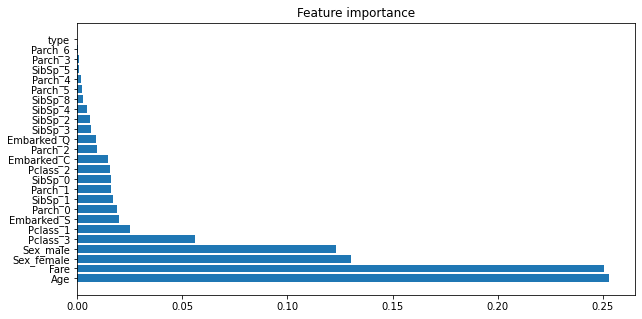

In [ ]:
def plot_importance(fit_model, feat_names):
    tmp_importance = fit_model.feature_importances_
    sort_importances = np.argsort(tmp_importance)[::-1]
    names = [feat_names[i] for i in sort_importances]
    plt.title('Feature importance')
    plt.barh(range(len(feat_names)), tmp_importance[sort_importances])
    plt.yticks(range(len(feat_names)), names, rotation=0)

rf_model.feature_importances_ 
plt.figure(figsize=(10, 5))
plot_importance(rf_model, train_x.columns)

En ce qui concerne l'importance des variables, le taux et l'âge sont les variables les plus pertinentes, suivies par le sexe de la personne. Dans le cas des algorithmes d'ensemble, la corrélation entre les variables, dans ce cas Sex_female et Sex_male, n'est pas un problème.

### 2. BOOSTING

Nous poursuivons avec les algorithmes de boosting qui, contrairement aux algorithmes de Bagging, dont Random Forest est un exemple, ils ajustent les poids, en donnant plus de importance aux variables qui ont prédit à tort. Ces algorithmes sont séquentiels.

#### 2.1 ADABOOST

In [ ]:
adaboost_model =AdaBoostClassifier(random_state=3).fit(train_x, train_y)

print(classification_report(test_y, adaboost_model.predict(test_x)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       117
           1       0.74      0.77      0.76        62

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



On peut voir que le modèle a une accuracy de 85%, meilleur que Random Forest et le recall pour la classe 1 a augmenté a 77%

In [ ]:
tree_decision_stump = DecisionTreeClassifier(max_depth=1, random_state=3).fit(train_x, train_y)

tree_model = DecisionTreeClassifier(random_state=3).fit(train_x, train_y) 

Ici, nous entrenons 4 modèles : Le premier est un arbre de décision avec une profondeur de 1, le même arbre sans restriction de profondeur, ensuite Random Forest sans restriction de profondeur (dans ce deux cas, l'algorithme se termine lorsque les feuilles sont pures ou lorsque les feuilles ont moins de 2 échantillons) et finalment AdaBoost qui utilise le premier model (DecisionTreeClassifier avec max_depth=1) mais qui ajuste chaque iterations les poids sur les variables

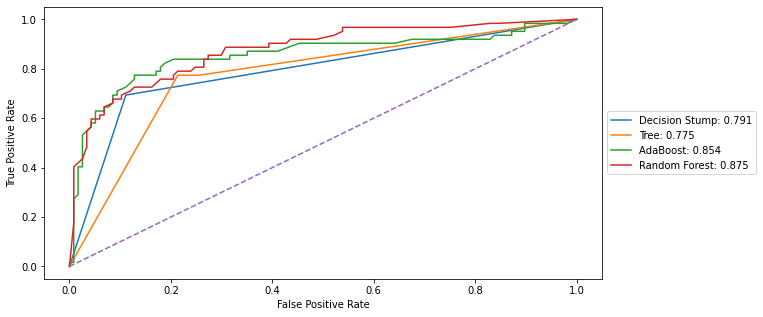

In [ ]:
def plot_roc(model, y_true, X_test, model_label=None):
    tmp_y_pred = model.predict_proba(X_test)[:, 1]
    false_positive_rates, true_positive_rates, _ = roc_curve(test_y, tmp_y_pred)
    store_auc = auc(false_positive_rates, true_positive_rates)
    if model_label is not None:
        tmp_label = "{}: {}".format(model_label, round(store_auc,3))
    else:
        tmp_label = None
    plt.plot(false_positive_rates, true_positive_rates, label=tmp_label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure(figsize=(10, 5))
plot_roc(tree_decision_stump,test_y,test_x, model_label = "Decision Stump") 
plot_roc(tree_model, test_y, test_x, model_label = "Tree")
plot_roc(adaboost_model,  test_y, test_x,model_label="AdaBoost") 
plot_roc(rf_model,test_y, test_x, model_label="Random Forest") 
plt.plot([0, 1], ls="--") 
plt.legend(loc='center left', bbox_to_anchor=(1, .5));


On peut voir que Random Forest et Adaboost ont une courbe ROC similaire. Avoir une prédiction correcte sur les valeurs positives sans augmenter autant le nombre de faux positifs, jusqu'à environ 0,6.

**Hyperparametres**

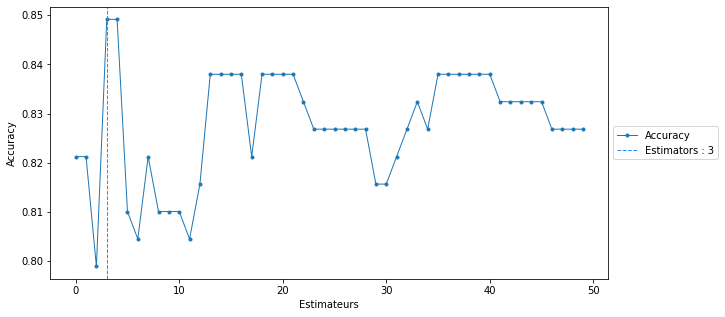

In [ ]:
store_acc = np.empty(adaboost_model.n_estimators) 
for index, value in enumerate(adaboost_model.staged_score(test_x, test_y)):     
    store_acc[index] = value

signal_optim = np.where(store_acc == np.max(store_acc))[0][0] 


plt.figure(figsize=(10, 5))
plt.plot(store_acc, '.-', lw=1, label="Accuracy")
plt.axvline(signal_optim, color='dodgerblue', lw=1, linestyle='--', label=f"Estimators : {signal_optim}") 
plt.xlabel('Estimateurs') 
plt.ylabel('Accuracy') 
plt.legend(loc='center left', bbox_to_anchor=(1, .5));






La definition de staged_score:

Cette méthode de générateur donne le score d'ensemble après chaque itération de boosting et permet donc un suivi, comme pour déterminer le score sur un jeu de test après chaque boost.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Ici on peut étudier la relation entre le score et le nombre d'estimateurs qui correspondent au nombre de weak learners utilisês. Dans ce cas, 3 estimateurs permettent de trouver le meilleur score, sans modifier les hyperparametres on a 85% de accuracy.

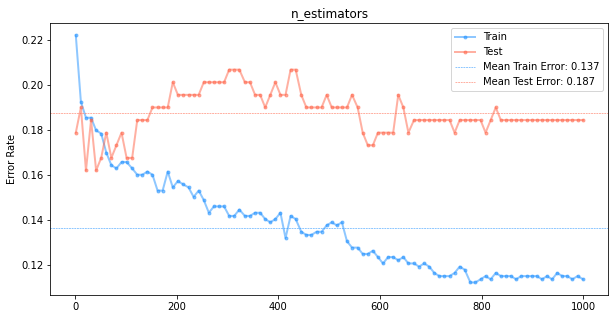

In [ ]:
def train_test_over_params(model, params, X_train, X_test, y_train, y_test, plot_mean=True):
    tmp_train, tmp_test = [], []
    values = list(params.values())[0]
    hyperparam = str(list(params.keys())[0])


    for i in values:
        params_spec = {hyperparam: i}
        tmp_model = model.set_params(**params_spec).fit(X_train, y_train)
        tmp_train.append(1 - accuracy_score(y_train, tmp_model.predict(X_train)))
        tmp_test.append(1 - accuracy_score(y_test, tmp_model.predict(X_test)))

    plt.plot(values, tmp_train, '.-',color='dodgerblue', label='Train', lw=2, alpha=.5)
    plt.plot(values, tmp_test,'.-', color='tomato', label='Test', lw=2, alpha=.5)

    if plot_mean is True:
        plt.axhline(np.mean(tmp_train), lw=.5, linestyle="--", color="dodgerblue", label="Mean Train Error: {}".format(round(np.mean(tmp_train), 3)))
        plt.axhline(np.mean(tmp_test), lw=.5,linestyle='--', color="tomato", label="Mean Test Error: {}".format(round(np.mean(tmp_test), 3)))

    plt.legend()
    plt.title(hyperparam)
    plt.ylabel("Error Rate")


def n_estimators_hyperparams():
    train_test_over_params(model=AdaBoostClassifier(random_state=2, n_estimators=100),
                           params= {'n_estimators': np.linspace(1, 1000, 100, endpoint=True, dtype=int)},
                           X_train = train_x, X_test = test_x, y_train = train_y, y_test=test_y)
plt.figure(figsize=(10, 5))
n_estimators_hyperparams() 

On montre le comportement de l'ensemble de test et d'entraînement lorsque le nombre d'estimateurs utilisés augmente. Bien que la précision du test d'entraînement a une tendance à augmenter avec le nombre d'estimateurs, ce sur-apprentissage n'est pas généralisable à l'ensemble d'entraînement et devient donc moins précis.

Calculating for depth = 1
Calculating for depth = 2
Calculating for depth = 3
Calculating for depth = 4
Calculating for depth = 5


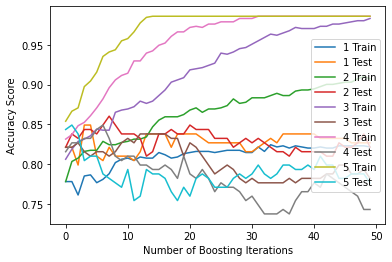

In [ ]:
depth_values = [1,2,3,4,5]
staged_score_valid = {}
staged_score_train = {}

for depth in depth_values:
    print("Calculating for depth = "+str(depth))
    instance = AdaBoostClassifier(n_estimators=50, base_estimator = DecisionTreeClassifier(max_depth = depth), random_state=2)
    instance.fit(train_x, train_y)
    errors = list(instance.staged_score(train_x, train_y))
    errors_v = list(instance.staged_score(test_x, test_y))
    plt.plot(errors, label=str(depth)+str(" Train"))
    plt.plot(errors_v, label=str(depth)+str(" Test"))
    staged_score_valid[depth] = errors_v
    staged_score_train[depth] = errors
    

plt.xlabel('Number of Boosting Iterations')  
plt.legend()
plt.ylabel('Accuracy Score')    
plt.show()



Ici, on montre que lorsque la profondeur des arbres utilisés comme apprenants augmente, l'accuracy du modèle pour l'ensemble d'apprentissage augmente, mais sur l'ensemble de test, elle diminue. Cela prouve que le modèle présente un overfitting à mesure que la profondeur et la complexité du modèle augmentent.

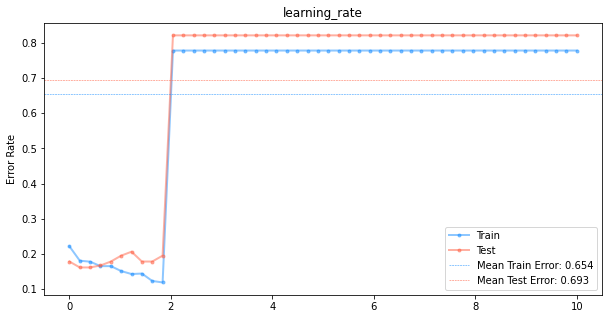

In [ ]:
def learning_rate_hyperparams():
    train_test_over_params(model=AdaBoostClassifier(random_state=2, n_estimators=200),
                           params= {'learning_rate': np.linspace(0.001, 10, 50, endpoint=True, dtype=float)},
                           X_train = train_x, X_test = test_x, y_train = train_y, y_test=test_y)
plt.figure(figsize=(10, 5))
learning_rate_hyperparams()

La definition de learning_rate:

Poids appliqué à chaque classificateur à chaque itération de boosting. Un taux d'apprentissage plus élevé augmente la contribution de chaque classificateur. Il y a un compromis entre les paramètres learning_rate et n_estimators.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

On peut voir ici que plus le taux d'apprentissage augmente, c'est-à-dire le poids appliqué aux week_learners, plus l'erreur augmente. La valeur optimal se trouve entre 0 et 2.




#### 2.2 GRADIENT BOOSTING

In [ ]:
gradientboost_model =GradientBoostingClassifier(random_state=2).fit(train_x, train_y)
print(classification_report(test_y, gradientboost_model.predict(test_x)))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       117
           1       0.79      0.73      0.76        62

    accuracy                           0.84       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.84      0.84      0.84       179



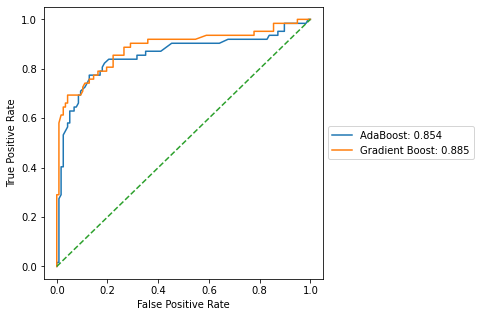

In [ ]:
plt.figure(figsize=(5, 5))
plot_roc(adaboost_model, test_y, test_x ,model_label="AdaBoost") 
plot_roc(gradientboost_model, test_y, test_x ,model_label="Gradient Boost") 
plt.plot([0, 1], ls="--") 
plt.legend(loc='center left', bbox_to_anchor=(1, .5))

**Hyperparametres**

In [ ]:
param_grid = {'n_estimators': [50, 200, 500, 1000], 'learning_rate': np.linspace(0.5, 3, 6, endpoint=True, dtype=float),'subsample': np.linspace(0.1, 1.0, 5, endpoint=True, dtype=float)}

gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=2), param_grid = param_grid, cv=5, n_jobs=-1).fit(train_x, train_y)

y_hat = gb_grid.best_estimator_.predict(test_x) 
print(classification_report(test_y, y_hat))


              precision    recall  f1-score   support

           0       0.88      0.85      0.86       117
           1       0.73      0.77      0.75        62

    accuracy                           0.82       179
   macro avg       0.80      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



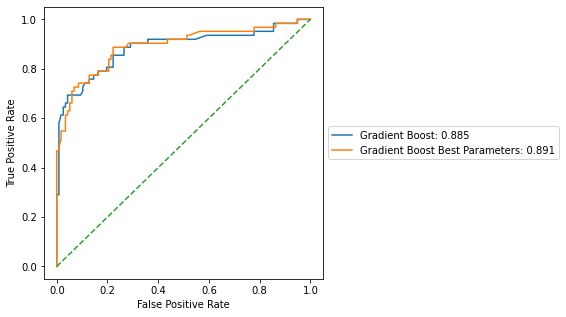

In [ ]:
plt.figure(figsize=(5, 5))
plot_roc(gradientboost_model, test_y, test_x ,model_label="Gradient Boost") 
plot_roc(gb_grid.best_estimator_, test_y, test_x ,model_label="Gradient Boost Best Parameters") 
plt.plot([0, 1], ls="--") 
plt.legend(loc='center left', bbox_to_anchor=(1, .5))


En comparant un Gradient Boost avec GridSearch pour trouver les hyperparamètres, nous pouvons voir qu'il a une meilleure courbe ROC, et un meilleur recall sur la classe 1 que dans le Gradient Boost sans GridSearch.  Mais l'optimisation des paramètres implique un coût de traitement supplémentaire.

Pour conclure, on peut dire que Random Forest, Adaboost et Gradient Boost ont des comportements similaires. Le choix de la méthode dépend beaucoup du type de problème, de la quantité de données et de l'erreur qu'on veut minimiser. 

Dans ce cas, la méthode du Gradient Boost avec GridSearch pour la recherche d'hyperparamètres donne de meilleurs résultats et, s'agissant d'un petit ensemble de données, le coût de calcul n'est pas trop élevé.

## 3. Prédiction par la regression logistique 

La prévision de la survie, variable binaire des données "Titanic", se prêtent à une régression logistique. Les versions pénalisées (Ridge, Lasso, elastic net, lars) du modèle linéaire général sont les algorithmes les plus développés dans scikit-learn au détriment de ceux plus classique de sélection de variables. Une version Lasso de la régression logistique est testée afin d'introduire la selection automatique des variables 

In [ ]:
# estimation et erreur de prévision du modèle complet sur l'echantillon test 
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression() 
titanic_logit=logit.fit(train_x, train_y) 
# Erreur
titanic_logit.score(test_x, test_y)
# Coefficients
titanic_logit.coef_

array([[-3.21577554e-02,  1.68241213e-03,  9.16058243e-01,
         1.23417899e-01, -1.03921511e+00,  1.27586189e+00,
        -1.27560085e+00,  1.07994268e+00,  9.81878576e-01,
         5.99137914e-01, -1.14329748e+00, -7.85547460e-01,
        -2.83309306e-01, -4.48543885e-01,  1.98724261e-01,
         6.33214200e-01, -6.26320479e-02,  1.98005342e-01,
        -4.58174255e-01, -3.41460067e-01, -1.67416397e-01,
         1.13055235e-01,  2.66555178e-01, -3.79349378e-01,
         2.61035317e-04]])

#### Fonction pour analyser la performance des modèles


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("AUC: {0:.4f}\n".format(roc_auc_score(y_train, clf.predict(X_train))))
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='AUC')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n") 
        print("AUC: {0:.4f}\n".format(roc_auc_score(y_test, clf.predict(X_test))))
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    

In [ ]:
print_score(titanic_logit, train_x, train_y,test_x, test_y, train=False)

Test Result:

AUC: 0.8149

accuracy score: 0.8324

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       117
           1       0.76      0.76      0.76        62

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179


Confusion Matrix: 
 [[102  15]
 [ 15  47]]



#### Réglage des paramètres

On test des parametres: 

On definit differents parametres possibles et on choisit les meilleurs parametres: 


In [ ]:
parameters = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],'max_iter': list(range(10,100))}

titanic_logit = LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42)

score = ['accuracy' ,'roc_auc']

titanic_logit_model = GridSearchCV(titanic_logit, parameters, cv = 10, scoring = score, refit = 'accuracy')
titanic_logit_model.fit(train_x, train_y)

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                          random_state=42),
             param_grid={'max_iter': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                      20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                      30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             refit='accuracy', scoring=['accuracy', 'roc_auc'])

In [ ]:
print('-----')
print(f'Meilleurs paramètres {titanic_logit_model.best_params_}')
print(
    f'Accuracy moyenne après validation croisée : ' + 
    f'{titanic_logit_model.best_score_:.3f}'
)
cross_valid_scores = {}
cross_valid_scores['LogReg'] = titanic_logit_model.best_score_

-----
Meilleurs paramètres {'max_iter': 86, 'penalty': 'l2'}
Accuracy moyenne après validation croisée : 0.784


In [ ]:
titanic_logit = LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42,max_iter= 86,penalty="l2")
titanic_logit.fit(train_x, train_y)

LogisticRegression(class_weight='balanced', max_iter=86, n_jobs=-1,
                   random_state=42)

La première façon de vérifier que le modèle a marché consiste à regarder la matrice de confusion.
Les coefficients sur la diagonale indiquent les éléments bien classés, les coefficients en dehors de ceux que le classifieur a mis dans la mauvaise classe.



In [ ]:
print_score(titanic_logit, train_x, train_y, test_x, test_y, train=False)

Test Result:

AUC: 0.8220

accuracy score: 0.8268

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.84      0.86       117
           1       0.72      0.81      0.76        62

    accuracy                           0.83       179
   macro avg       0.81      0.82      0.81       179
weighted avg       0.83      0.83      0.83       179


Confusion Matrix: 
 [[98 19]
 [12 50]]



In [ ]:
titanic_logit.score(test_x,test_y)

0.8268156424581006

In [ ]:
conf = confusion_matrix(test_y, titanic_logit.predict(test_x))
cf = pd.DataFrame(conf, columns=['Survivants','morts'])
cf.index = ['vrai ','faux']
cf

,Survivants,morts
vrai,98,19
faux,12,50


Un classifieur construit une frontière entre deux classes, la distance d’un point à la frontière constitue une information importante. Plus elle est grande, plus le modèle est confiant. Cette distance est souvent appelée score.

In [ ]:
# Voyons comment le score est distribué :
score = titanic_logit.decision_function(test_x)
dfsc= pd.DataFrame(score, columns=['score'])
dfsc['Survived'] = test_y
dfsc.head()

,score,Survived
0,-2.184958,0
1,-1.700584,0
2,-1.893505,0
3,2.406457,1
4,2.505644,1


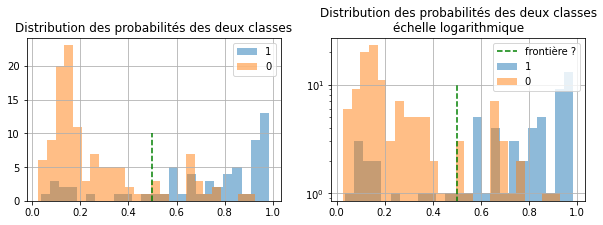

In [ ]:
proba = titanic_logit.predict_proba(test_x)[:, 1]
dfpr = pandas.DataFrame(proba, columns=['proba'])
dfpr['survived'] = test_y

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,3))
dfpr[dfpr['survived'] == 1]['proba'].hist(bins=25, label='1', alpha=0.5, ax=ax[0])
dfpr[dfpr['survived'] == 0]['proba'].hist(bins=25, label='0', alpha=0.5, ax=ax[0])
ax[0].set_title('Distribution des probabilités des deux classes')
ax[0].legend();
dfpr[dfpr['survived'] ==1]['proba'].hist(bins=25, label='1', alpha=0.5, ax=ax[1])
dfpr[dfpr['survived'] ==0]['proba'].hist(bins=25, label='0', alpha=0.5, ax=ax[1])
ax[0].plot([0.5, 0.5], [0, 10], 'g--', label="frontière ?")
ax[1].plot([0.5, 0.5], [0, 10], 'g--', label="frontière ?")
ax[1].set_yscale('log')
ax[1].set_title('Distribution des probabilités des deux classes\néchelle logarithmique')
ax[1].legend();

Plus l’aire commune aux deux distributions est petite, plus le modèle est confiant. Cette aire commune est reliée à la courbe ROC.


### Sélection de Variables explicatives grace à la regression logistique 

L'élimination des caractéristiques récursives, ou bref RFE, est un algorithme largement utilisé pour sélectionner les caractéristiques les plus pertinentes pour prédire la variable cible dans un modèle prédictif - régression ou classification. RFE applique un processus de sélection en arrière pour trouver la combinaison optimale de fonctionnalités. Tout d'abord, il construit un modèle basé sur toutes les fonctionnalités et calcule l'importance de chaque fonctionnalité dans le modèle. Ensuite, il classe les fonctionnalités et supprime celles qui ont le moins d'importance de manière itérative en fonction des métriques d'évaluation du modèle.

Le RFE permet la sélection de fonctionnalités importantes lors de la création de modèles prédictifs.

In [ ]:
# Build a logreg and compute the feature importances
model = LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42,max_iter= 86,penalty="l2")
# create the RFE model and select 13 attributes
rfe = RFE(estimator=LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42,max_iter= 86,penalty="l2"), n_features_to_select=13)
rfe = rfe.fit(train_x, train_y)
# summarize the selection of the attributes
print('Variables selectionnées: %s' % list(train_x.columns[rfe.support_]))

Variables selectionnées: ['Pclass_1', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_8', 'Parch_1', 'Parch_4', 'Parch_5']


RFECV effectue RFE dans une boucle de validation croisée pour trouver le nombre optimal ou le meilleur nombre de fonctionnalités. Ci-après une élimination récursive de caractéristiques appliquée sur la régression logistique avec réglage automatique du nombre de caractéristiques sélectionnées avec validation croisée. 

Nombre optimal de variables: 21
Variables selectionnées: ['Pclass_1', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


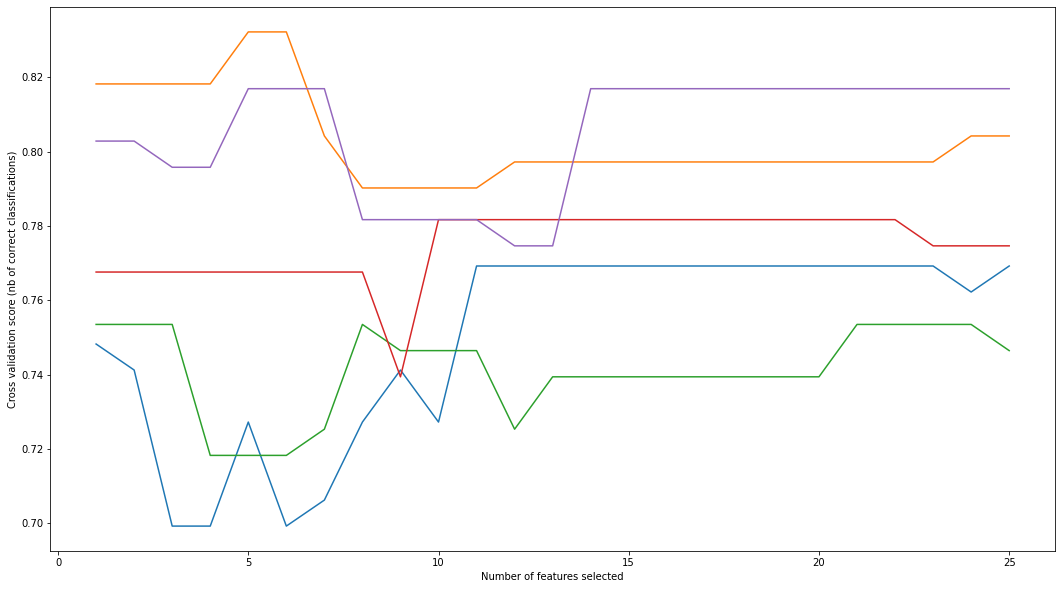

In [ ]:
# Creation de l'objet RFE et calcul du score de validation croisée.
# La notation "précision" est proportionnelle au nombre de classements corrects
rfecv = RFECV(estimator=LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42,max_iter= 86,penalty="l2"), step=1, cv=5, scoring='accuracy')
rfecv.fit(train_x, train_y)
print("Nombre optimal de variables: %d" % rfecv.n_features_)
print('Variables selectionnées: %s' % list(train_x.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(18,10))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Comme on le voit dans le graphique 21 variables selectionnées (sur les 26) permettent d'obtenir de manière générale une meilleure classification des données. Nous avons donc sélectionné les variables les plus pertinentes pour prédire la variable cible dans notre modèle prédictif.



In [ ]:
train_x_rfe= train_x[['Pclass_1', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
# check classification scores of logistic regression
logreg = LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42,max_iter= 86,penalty="l2")
logreg.fit(train_x, train_y)
pred_y = logreg.predict(test)
pred_y_proba = logreg.predict_proba(test_x)[:, 1]
[fpr, tpr, thr] = roc_curve(test_y, pred_y_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(test_y, pred_y))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(test_y, pred_y_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))
  

Train/Test split results:
LogisticRegression accuracy is 0.827
LogisticRegression log_loss is 0.427
LogisticRegression auc is 0.858


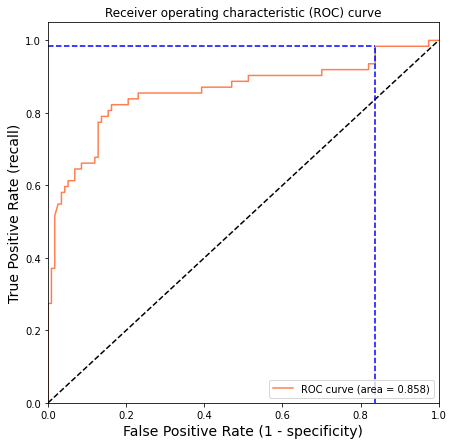

Using a threshold of 0.110 guarantees a sensitivity of 0.984 and a specificity of 0.162, i.e. a false positive rate of 83.76%.


In [ ]:
idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

#### Regression par LASSO

Il est préférable de centrer et réduire les variables dans la régression régularisée afin que le coefficient de pénalité α (il est noté λ dans le cours, RAK, 2018) agisse de manière homogène sur l’ensemble des coefficients de la régression.

In [ ]:
#centrer et réduire les données d'apprentissage
sc = StandardScaler()
train_x =sc.fit_transform(train_x)

#affichage des moyennes après transformations
print(np.mean(train_x,axis=0))
#affichage des variances apres transformation 
print(np.var(train_x,axis=0))

[ 1.89611123e-16 -2.61962736e-17  1.02290211e-16 -1.74641824e-17
 -6.98567296e-17 -2.99385984e-17  1.44703226e-16  1.49692992e-16
  2.86911568e-17  6.48669632e-17 -6.48669632e-17  6.73618464e-17
 -2.74437152e-17 -2.49488320e-18 -4.49078976e-17 -6.73618464e-17
 -3.74232480e-18 -1.74641824e-17 -2.99385984e-17 -3.11860400e-17
 -2.49488320e-18 -4.98976640e-18  1.99590656e-17 -9.23106785e-17
  0.00000000e+00]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]



Les moyennes des variables transformées sont bien nulles (aux erreurs de troncature près), et leurs variances sont égales à 1.

Modélisation avec les paramètres par défaut (α = 1.0)
Nous pouvons lancer la régression Lasso . Nous précisons que la constante n’est pas nécessaire puisque toutes les variables sont centrées, et qu’il n’est pas utile de les normaliser puisqu’elles ont été standardisées en amont. Les autres paramètres sont laissés pas défaut.

In [ ]:
#régression Lasso, paramètres par défaut (alpha = 1.0)
regLasso1 = Lasso(fit_intercept=False,normalize=False)
print(regLasso1)
Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000, normalize=False, positive=False, precompute=False, random_state=None,
selection='cyclic', tol=0.0001, warm_start=False)

Lasso(fit_intercept=False, normalize=False)


Lasso(fit_intercept=False, normalize=False)

Nous ne savons pas vraiment si la valeur par défaut du coefficient de pénalité est α = 1.0 est adaptée à notre jeu de données. Faisons confiance à « scikit-learn » pour l’instant. Nous lançons la régression sur les données d’apprentissage (centrées et réduites) et nous affichons les coefficients estimés :


In [ ]:
#apprentissage
regLasso1.fit(train_x,train_y)
#les coefficients
print(regLasso1.coef_)

[-0.  0.  0.  0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0. -0.  0.  0. -0.  0.]


Ils sont tous nuls. Difficile de réaliser une prédiction performante avec ça. Manifestement, la valeur (α = 1.0) ne convient pas.
Comment peut-on faire pour déterminer une valeur de α qui convient ?


Lorsque α est trop élevé, tous les coefficients de la régression sont nuls, nous en avons une illustration ici ; lorsque α est trop faible, proche de 0, nous obtenons les coefficients de la
régression linéaire multiple usuelle. Il faut trouver le juste milieu et c’est toute la difficulté de la régression Lasso. L’outil « Lasso path » peut nous y aider. Il produit un graphique qui met en relation les différentes versions de α avec les coefficients estimés. La régression Lasso, contrairement à Ridge, permet de réaliser une sélection de variables en mettant à zéro sélectivement les coefficients. Nous voyons ainsi se dessiner des scénarios de solutions (au sens « différents ensembles de variables sélectionnées ») tout au long du « Lasso path ».

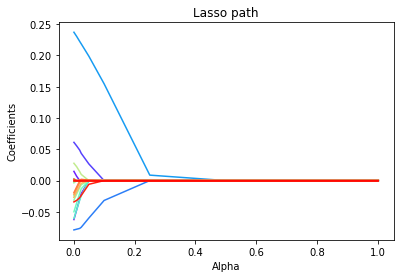

In [ ]:
#lasso path (10 valeurs de alpha à tester)
my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])


#obtention des valeurs des coefs. corresp.
#La fonction lasso_path() permet de produire les coefficients estimés correspondants 
alpha_for_path, coefs_lasso, _ = lasso_path(train_x,train_y,alphas=my_alphas)

 #dim. matrice des coefficients
 #coefs_lasso est la matrice des coefficients avec 25 lignes (parce que 25 variables explicatives) et 10 colonnes (parce que 10 valeurs différentes de α essayées).

#jeu de couleurs
couleurs = cm.rainbow(np.linspace(0,1,25))
#graphique lasso path (une courbe par variable)
for i in range(coefs_lasso.shape[0]):
    plt.plot(alpha_for_path,coefs_lasso[i,:],c=couleurs[i])
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.show()

Pour α = 1.0, tous les coefficients sont nuls effectivement. Pour α = 0.2, deux des coefficients sont non-nuls, ce qui correspond à un scénario où deux seules explicatives sont actives dans la régression. Etc.
De fait, pour chaque valeur de α, nous pouvons identifier le nombre de variables sélectionnées :

In [ ]:
#nombre de coefs. non-nuls pour chaque alpha
nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
#affichage mieux organisé alpha vs. nombre de coefs non-nuls
print(pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero}))

   alpha  Nb non-zero coefs
0  1.000                  0
1  0.800                  0
2  0.500                  0
3  0.250                  1
4  0.100                  2
5  0.050                  5
6  0.025                 11
7  0.020                 14
8  0.010                 14
9  0.001                 19


Ce tableau est plus engageant sous une forme graphique.

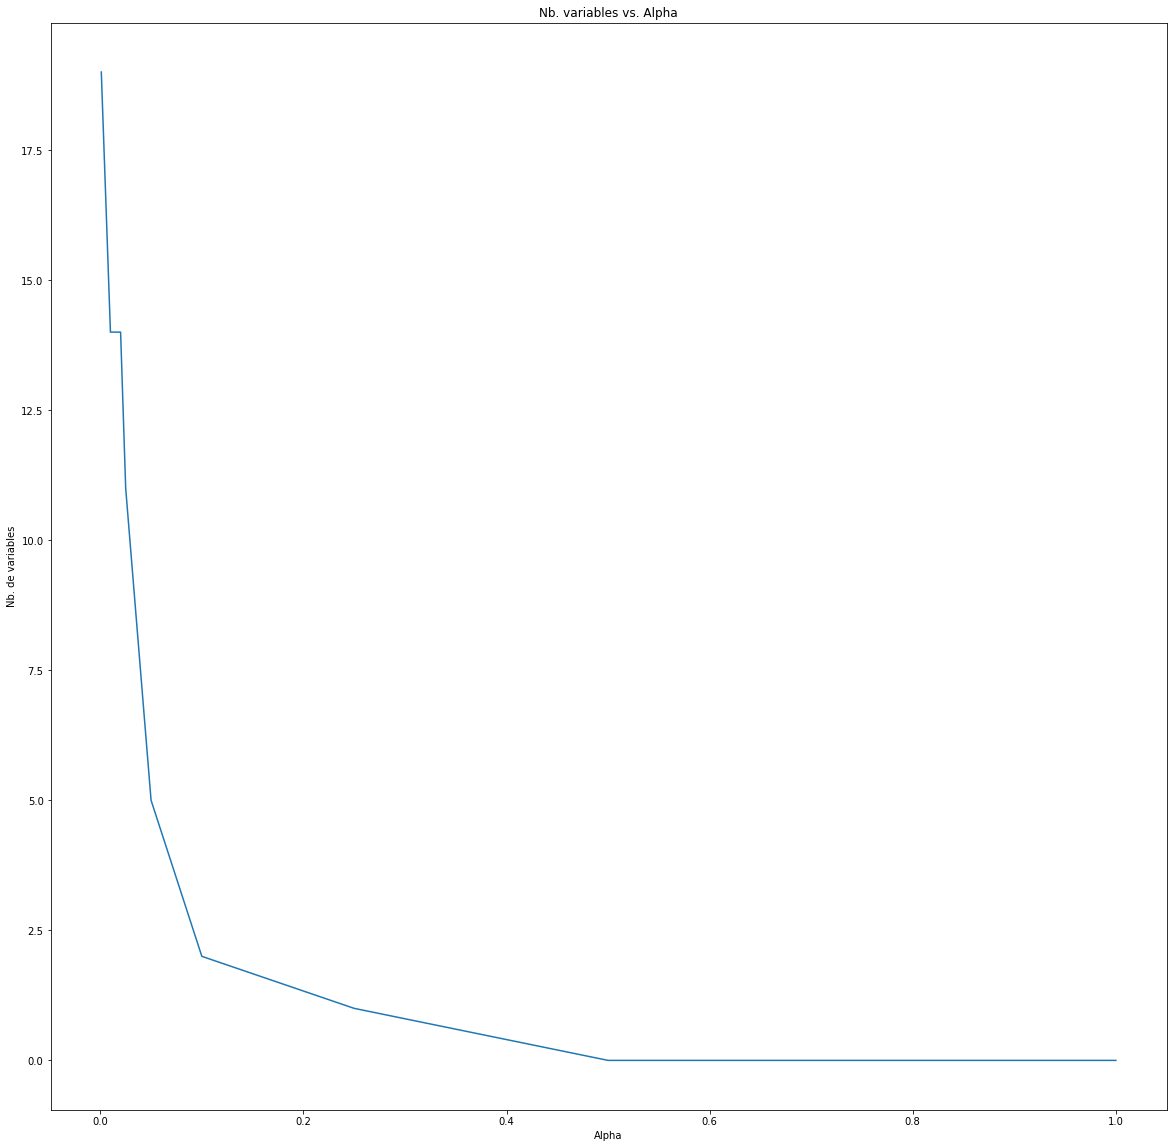

In [ ]:
plt.plot(alpha_for_path,nbNonZero) 
plt.xlabel('Alpha')
plt.ylabel('Nb. de variables') 
plt.title('Nb. variables vs. Alpha') 
plt.show()

Nous pouvons par exemple identifier les 2 variables sélectionnées pour α = 0.1.

In [ ]:
#nom des variables
nom_var = train.columns
#coefficients pour alpha=0.25 (colonne n°3)
coefs25 = coefs_lasso[:,3]
#affichage dU coefficient pour alpha = 0.25
print(pd.DataFrame({'Variables':nom_var,'Coefficients':coefs25}))
#La seule variable selectionnée est sex_female pour ce alpha 

     Variables  Coefficients
0          Age     -0.000000
1         Fare      0.000000
2     Pclass_1      0.000000
3     Pclass_2      0.000000
4     Pclass_3     -0.000000
5   Sex_female      0.008701
6     Sex_male     -0.000000
7      SibSp_0     -0.000000
8      SibSp_1      0.000000
9      SibSp_2      0.000000
10     SibSp_3     -0.000000
11     SibSp_4     -0.000000
12     SibSp_5     -0.000000
13     SibSp_8     -0.000000
14     Parch_0     -0.000000
15     Parch_1      0.000000
16     Parch_2      0.000000
17     Parch_3      0.000000
18     Parch_4     -0.000000
19     Parch_5     -0.000000
20     Parch_6     -0.000000
21  Embarked_C      0.000000
22  Embarked_Q      0.000000
23  Embarked_S     -0.000000
24        type      0.000000


Nous disposons de scénarios de solutions pour différentes versions de α. Mais nous ne savons pas laquelle est la plus performante en prédiction. Dans cette section, nous utilisons la validation croisée LassoCV() pour l’identifier.

In [ ]:
#outil pour la détection de la solution la plus performante en validation croisée 
#random_state = 0 pour fixer l’initialisation du générateur de nombre aléatoire 
#cv = 5 pour 5-fold validation croisée
from sklearn.linear_model import LassoCV
lcv = LassoCV(alphas=my_alphas,normalize=False,fit_intercept=False,random_state=0,cv=5)
#lancement sur l'échantillon d'apprentissage
lcv.fit(train_x,train_y)

LassoCV(alphas=array([0.001, 0.01 , 0.02 , 0.025, 0.05 , 0.1  , 0.25 , 0.5  , 0.8  ,
       1.   ]),
        cv=5, fit_intercept=False, normalize=False, random_state=0)

In [ ]:
#valeurs des MSE en validation croisée
print(lcv.mse_path_)
# La propriété mse_path_ est une matrice (10 x 5) : 10 parce que 10 versions de α ont été testées ; 5 parce que nous avons demandé une 5-fold validation croisée.

Nous calculons la moyenne pour disposer d’une mesure de performance synthétique pour chaque scénario. Puis nous affichons un graphique mettant en relation α et le MSE (moyen) en validation croisée.

   alpha        MSE
0  1.000   0.393263
1  0.800   0.393263
2  0.500   0.393263
3  0.250   0.388908
4  0.100   0.331665
5  0.050   0.317740
6  0.025   0.310723
7  0.020   0.309001
8  0.010  12.545439
9  0.001  98.474984


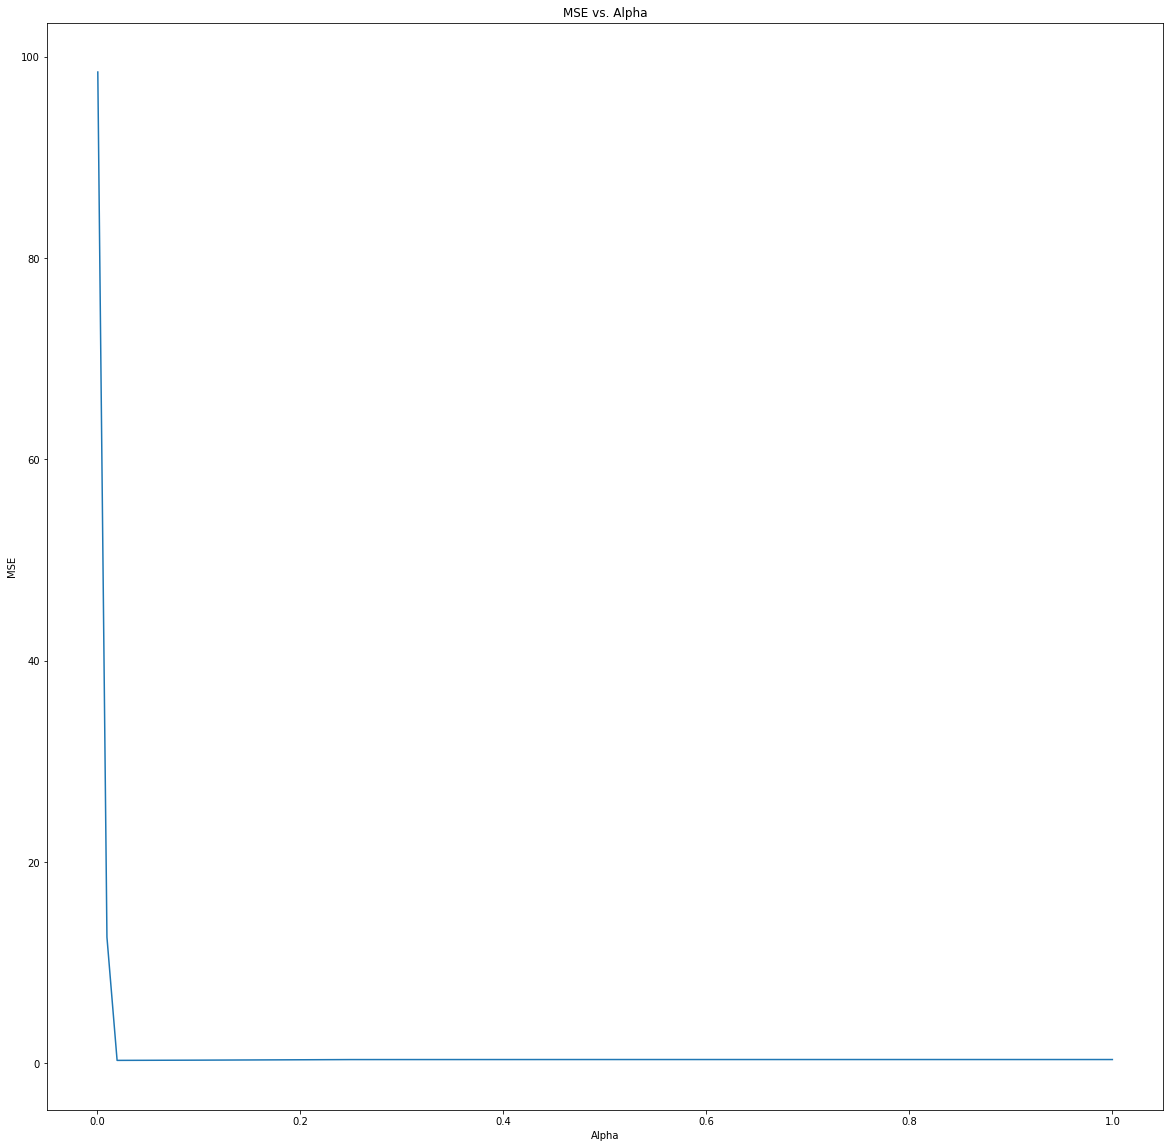

In [ ]:
#moyenne mse en validation croisée pour chaque alpha
avg_mse = np.mean(lcv.mse_path_,axis=1)

#alphas vs. MSE en cross-validation
print(pd.DataFrame({'alpha':lcv.alphas_,'MSE':avg_mse}))

plt.plot(,avg_mse)
plt.xlabel('MSE')
plt.ylabel('Alpha')
plt.title('MSE vs. Alpha')
plt.show()

In [ ]:
 #best alpha
print(lcv.alpha_) #0.02

0.02


α = 0.02 est la solution qui minimise le MSE, elle est composée de 14 variables explicatives c.-à-d. 14 coefficients sont différents de zéro dans le modèle.

In [ ]:
#régression Lasso avec le paramètres optimal(alpha = 0.02)
regLasso1 = Lasso(fit_intercept=False,normalize=False)
print(regLasso1)
Lasso(alpha=0.02, copy_X=True, fit_intercept=False, max_iter=1000, normalize=False, positive=False, precompute=False, random_state=None,
selection='cyclic', tol=0.0001, warm_start=False)
#apprentissage
regLasso1.fit(train_x,train_y)


Lasso(fit_intercept=False, normalize=False)


Lasso(fit_intercept=False, normalize=False)

#### Evaluation dans l'echantillon Test


Pour appliquer le modèle optimal (α = 0.02), nous devons tout d’abord centrer et réduire les variables explicatives de l’échantillon test en utilisant les paramètres (moyennes, écarts-type) calculés sur l’échantillon d’apprentissage.

In [ ]:
 #transformation des variables des données test
test_x = sc.transform(test_x)

Nous pouvons maintenant appliquer le modèle.

In [ ]:
#prediction avec ce modèle
y_Lasso = lcv.predict(test_x)

Nous disposons d’une prédiction standardisée de la variable à prédire, il faut la dé- standardiser pour qu’elle soit exprimée dans l’unité originelle. 

In [ ]:
 #dé-standardization de la prédiction, [-1] parce que y est en dernière position
ypLasso = y_Lasso*np.sqrt(sc.var_[-1]) + sc.mean_[-1]

Nous pouvons dès lors confronter ces valeurs prédites avec les valeurs observées sur l’échantillon test.

In [ ]:
#performances en prédiction
print(mean_squared_error(test_y,ypLasso))

0.6536312849162011


In [ ]:
print_score(regLasso1.fit(train_x,train_y), train_x, train_y,test_x, test_y, train=False)

Test Result:

AUC: 0.5000

accuracy score: 0.6536

Classification Report: 
               precision    recall  f1-score   support

           0       0.65      1.00      0.79       117
           1       0.00      0.00      0.00        62

    accuracy                           0.65       179
   macro avg       0.33      0.50      0.40       179
weighted avg       0.43      0.65      0.52       179


Confusion Matrix: 
 [[117   0]
 [ 62   0]]



Nous obtenons une MSE = 0.6536312849162011. Le score obtenu est bien moins satisfaisant(plus la MSE est faible, meilleur est le modèle) qu’avec la régression usuelle .